# Studying a model performance with synthetic data

Synthetic data have been created for each class, using as input the pictures that all models misclassify. The idea is the following: Maybe having more pics similar to the misclassified ones we can improve the performance of the model in that areas.

In this notebook the train set of kitchen and bathroom classes have been populated with synthetic data (480 for bathroom, 250 for kitchen), then all classes have approx the same volume.

- The study of what pics were generated synthetically can be found here => https://github.com/albertovpd/viu_tfm-deep_vision_classification/tree/synthetic_data_study

- They were created using the pytorch implementation of this repo => https://github.com/mit-han-lab/data-efficient-gans


In [1]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 22 21:42:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libs

In [4]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import load_model # Sequential
from tensorflow.keras import layers 

# optimization
from tensorflow.keras.optimizers import SGD #Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# nn architectures, metrics, viz & reports => written in my_functions202202 file
import sys
sys.path.append("/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src")
from my_functions202202 import generic_last_2layers, plotting_model, model_evaluation, classification_report_pic, confusion_matrix_report

import numpy as np
%matplotlib inline

# navigating through folder
import os

- paths

In [5]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
train_folder = base_folder + "input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/"
val_folder = base_folder + "input/dataset_synth_data-augmented_bathroom_kitchen/val_ds/"
test_folder = base_folder+"input/dataset_synth_data-augmented_bathroom_kitchen/test_ds/"

src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [6]:
#my_functions202202.py

- common parameters

In [7]:
image_size = (128,128)
batch_size = 128
epochs = 250
opt = SGD(momentum=0.9) 

In [8]:
base_model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) 
models_dict = {"resnet50_NOdataAug_dropoutFirst007": 
         generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.07)
         }

In [9]:
train_ds = image_dataset_from_directory(
    train_folder,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

Found 4328 files belonging to 5 classes.


In [10]:
val_ds = image_dataset_from_directory(
    val_folder,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

Found 902 files belonging to 5 classes.


In [11]:
test_ds = image_dataset_from_directory(
    test_folder,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

Found 750 files belonging to 5 classes.


['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/  =>  /content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Dinning  =>  /content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/ 806
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Bedroom  =>  /content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/ 878
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_synth_data-augmented_bathroom_kitchen/train_ds/Kitchen  =>  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


34/34 [==============================] - 17s 352ms/step - loss: 85.2460 - accuracy: 0.4499 - val_loss: 299.5474 - val_accuracy: 0.2494
Epoch 2/250
34/34 [==============================] - 10s 299ms/step - loss: 403.4250 - accuracy: 0.0021 - val_loss: 188.8589 - val_accuracy: 0.1807
Epoch 3/250
34/34 [==============================] - 10s 303ms/step - loss: 339.7605 - accuracy: 0.0917 - val_loss: 67.5403 - val_accuracy: 0.4302
Epoch 4/250
34/34 [==============================] - 10s 304ms/step - loss: 257.1794 - accuracy: 0.2576 - val_loss: 69.0988 - val_accuracy: 0.4047
Epoch 5/250
34/34 [==============================] - 10s 308ms/step - loss: 199.0808 - accuracy: 0.2655 - val_loss: 60.3877 - val_accuracy: 0.4302
Epoch 6/250
34/34 [==============================] - 10s 302ms/step - loss: 225.5258 - accuracy: 0.2283 - val_loss: 69.1871 - val_accuracy: 0.4302
Epoch 7/250
34/34 [==============================] - 10s 305ms/step - loss: 222.1281 - accuracy: 0.2401 - val_loss: 45.2775 - val

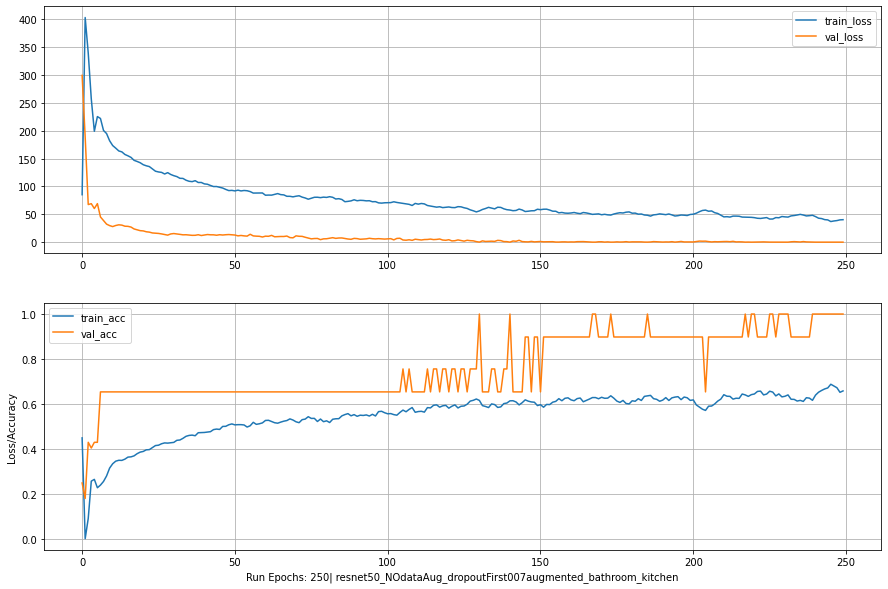

6/6 [==============================] - 2s 296ms/step - loss: 33.2680 - accuracy: 0.6853
              precision    recall  f1-score   support

     Bedroom       1.00      1.00      1.00       220
    Bathroom       1.00      1.00      1.00        92
     Dinning       1.00      1.00      1.00       202
  Livingroom       1.00      1.00      1.00       225
     Kitchen       1.00      1.00      1.00       163

    accuracy                           1.00       902
   macro avg       1.00      1.00      1.00       902
weighted avg       1.00      1.00      1.00       902



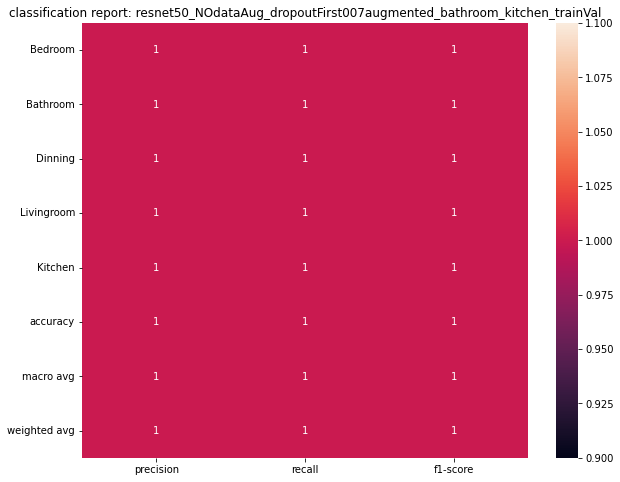

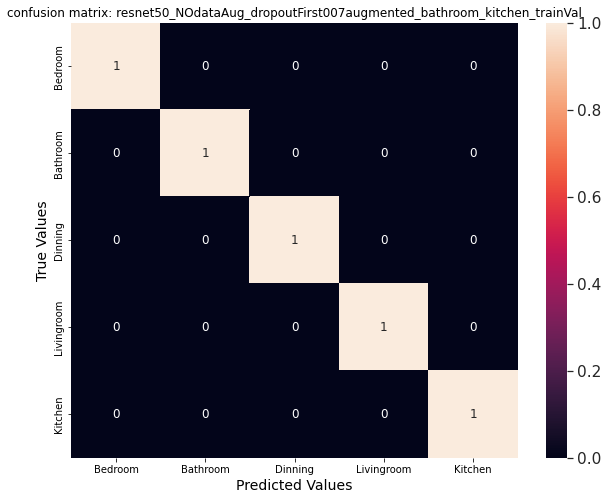

6/6 [==============================] - 1s 228ms/step - loss: 33.2680 - accuracy: 0.6853
              precision    recall  f1-score   support

     Bedroom       0.82      0.77      0.79       160
    Bathroom       0.50      0.84      0.63        89
     Dinning       0.63      0.70      0.66       135
  Livingroom       0.61      0.66      0.63       137
     Kitchen       0.87      0.57      0.69       229

    accuracy                           0.69       750
   macro avg       0.69      0.71      0.68       750
weighted avg       0.72      0.69      0.69       750



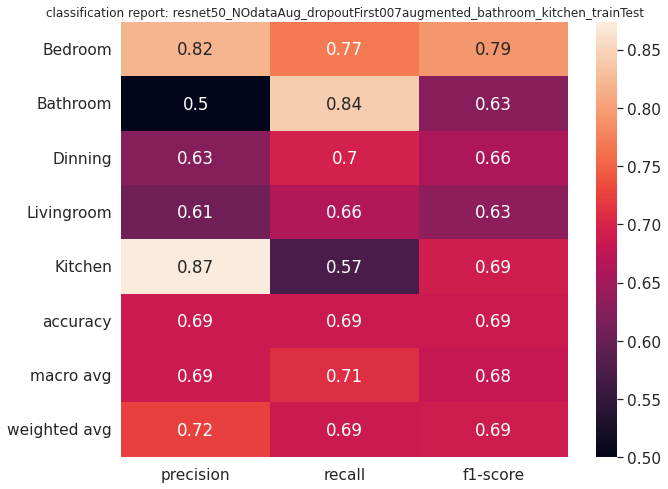

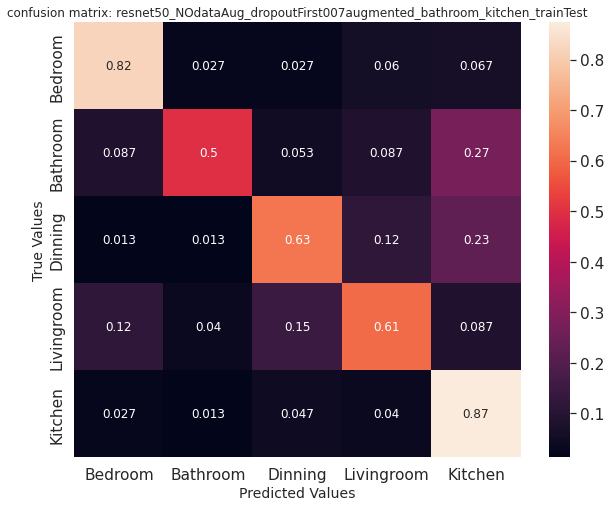

In [12]:
# name for pics
f = "augmented_bathroom_kitchen"

class_names = train_ds.class_names
print(class_names)

# checking numbers non sense now because all have same volume
paths = [train_folder, val_folder, test_folder]
for p in paths:
    for dir,subdir,files in os.walk(p):
        print(dir,' => ', p, str(len(files)))

# calling model
model_name, nn = list(models_dict.items())[0]
print("\n", model_name)
nn.summary()

nn.compile( optimizer = opt, #"adam", 
              loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
              metrics=['accuracy'] # "recall"
              )

# ====== USING VAL DATASET ======

history = nn.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      #callbacks = callbacks # <=== REMOVE CALLBACK for full results
      )

number_of_epochs_it_ran = len(history.history['loss']) 
print("run epochs: ",number_of_epochs_it_ran)
name = model_name+ f 
#models_dict[m].save(output_folder+name+".h5")

# saving model accuracy/loss graph
plotting_model(history,number_of_epochs_it_ran, name, output_folder, "val") 

# saving model metrics to json
evaluation = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
model_evaluation(evaluation, output_folder, name+"_trainVal")

# get inferences
y_pred_val_float = nn.predict(val_ds)
y_pred_val = np.argmax(y_pred_val_float, axis=1)

# get real labels
y_target = tf.concat([y for x, y in val_ds], axis=0) 

# classification and confusion matrix reports
classification_report_pic(y_pred_val, y_target,  class_names, output_folder, name+"_trainVal")
confusion_matrix_report(y_pred_val, y_target, class_names, output_folder, name+"_trainVal")

# ====== USING TEST DATASET ======

# saving model metrics to json
evaluation_test = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
model_evaluation(evaluation_test, output_folder, name+"_trainTest")

# get inferences
y_pred_test_float = nn.predict(test_ds)
y_pred_test = np.argmax(y_pred_test_float, axis=1)

# get real labels for val_ds
y_target_test = tf.concat([y for x, y in test_ds], axis=0) 

# classification and confusion matrix reports
classification_report_pic(y_pred_test, y_target_test,  class_names, output_folder, name+"_trainTest")
confusion_matrix_report(y_pred_test, y_target_test, class_names, output_folder, name+"_trainTest")